# Geração de Dataset de Sinais de Qualidade de Energia Elétrica

Este notebook gera um dataset de 10.000 sinais sintéticos de qualidade de energia elétrica, distribuídos em 16 classes de distúrbios.

## 1. Importar Bibliotecas e Configurar Ambiente

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import logging
import sys
from pathlib import Path
import time
import pickle

# Configurar logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[
        logging.StreamHandler(sys.stdout)
    ]
)

print("Bibliotecas importadas com sucesso!")
print(f"NumPy version: {np.__version__}")

Bibliotecas importadas com sucesso!
NumPy version: 2.3.5


## 2. Importar o Gerador de Sinais

Certifique-se de que o arquivo `power_quality_generator.py` está no mesmo diretório deste notebook.

In [2]:
# Importar o gerador (assumindo que o arquivo .py está salvo como power_quality_generator.py)
from power_quality_generator import PowerQualitySignalGenerator

print("Gerador importado com sucesso!")

Gerador importado com sucesso!


## 3. Configurar Parâmetros do Dataset

In [3]:
# Parâmetros
DATASET_PATH = "dataset"  # Diretório onde o dataset será salvo
SAMPLES_PER_CLASS = 625*4   # Amostras por classe

# ESCOLHER CLASSES DESEJADAS
# Opção 1: Todas as classes (padrão)
SELECTED_CLASSES = ['C1_Normal',
                    'C2_Sag',
                    'C3_Swell',
                    'C4_Interruption',
                    'C5_Flicker',
                    'C6_Transient',
                    'C7_Harmonics',
                    'C8_Notch',
                    'C9_Spike']  # None = todas as classes

# Opção 2: Escolher classes específicas (descomente para usar)
# SELECTED_CLASSES = ['C1_Normal', 'C2_Sag', 'C3_Swell']  # Apenas 3 classes
# SELECTED_CLASSES = ['C1_Normal', 'C7_Harmonics', 'C10_Sag_Transient', 'C12_Sag_Harmonic']  # 4 classes

print(f"Configuração do Dataset:")
print(f"  Diretório: {DATASET_PATH}")
print(f"  Amostras por classe: {SAMPLES_PER_CLASS}")
if SELECTED_CLASSES is None:
    print(f"  Classes selecionadas: TODAS (16 classes)")
    print(f"  Total de amostras: {SAMPLES_PER_CLASS * 16}")
else:
    print(f"  Classes selecionadas: {len(SELECTED_CLASSES)} classes")
    print(f"  Total de amostras: {SAMPLES_PER_CLASS * len(SELECTED_CLASSES)}")
    for cls in SELECTED_CLASSES:
        print(f"    • {cls}")

Configuração do Dataset:
  Diretório: dataset
  Amostras por classe: 2500
  Classes selecionadas: 9 classes
  Total de amostras: 22500
    • C1_Normal
    • C2_Sag
    • C3_Swell
    • C4_Interruption
    • C5_Flicker
    • C6_Transient
    • C7_Harmonics
    • C8_Notch
    • C9_Spike


## 4. Criar o Gerador

In [4]:
# Criar instância do gerador
generator = PowerQualitySignalGenerator(
    dataset_path=DATASET_PATH,
    f=60.0,                    # Frequência nominal: 60 Hz
    duration=0.2,              # Duração do sinal: 0.2 segundos
    samples_per_cycle=128      # 256 amostras por ciclo
)

print("\nGerador criado com sucesso!")
print(f"\nEspecificações:")
print(f"  Frequência de amostragem: {generator.fs} Hz")
print(f"  Total de amostras por sinal: {generator.n_samples}")
print(f"  Duração: {generator.duration} s")

2025-11-25 22:23:13,179 - PowerQualityGenerator - INFO - Inicializado gerador de sinais PQ
2025-11-25 22:23:13,181 - PowerQualityGenerator - INFO -   Frequencia: 60.0 Hz
2025-11-25 22:23:13,181 - PowerQualityGenerator - INFO -   Duracao: 0.2 s
2025-11-25 22:23:13,181 - PowerQualityGenerator - INFO -   Amostras: 1536
2025-11-25 22:23:13,182 - PowerQualityGenerator - INFO -   Fs: 7680.0 Hz

Gerador criado com sucesso!

Especificações:
  Frequência de amostragem: 7680.0 Hz
  Total de amostras por sinal: 1536
  Duração: 0.2 s


## 5. Verificar Classes Disponíveis

In [5]:
# Listar todas as classes disponíveis
all_class_names = list(generator.signal_classes.keys())

print(f"\nClasses disponíveis ({len(all_class_names)}):")
for i, class_name in enumerate(all_class_names, 1):
    print(f"  {i:2d}. {class_name}")

# Definir classes que serão geradas
if SELECTED_CLASSES is None:
    class_names = all_class_names
else:
    class_names = SELECTED_CLASSES
    # Validar se as classes existem
    for cls in class_names:
        if cls not in all_class_names:
            raise ValueError(f"Classe '{cls}' não existe! Classes válidas: {all_class_names}")

print(f"\n✓ Classes que serão geradas ({len(class_names)}):")
for i, class_name in enumerate(class_names, 1):
    print(f"  {i:2d}. {class_name}")


Classes disponíveis (16):
   1. C1_Normal
   2. C2_Sag
   3. C3_Swell
   4. C4_Interruption
   5. C5_Flicker
   6. C6_Transient
   7. C7_Harmonics
   8. C8_Notch
   9. C9_Spike
  10. C10_Sag_Transient
  11. C11_Swell_Transient
  12. C12_Sag_Harmonic
  13. C13_Interruption_Harmonic
  14. C14_Swell_Harmonic
  15. C15_Flicker_Harmonic
  16. C16_Transient_Harmonic

✓ Classes que serão geradas (9):
   1. C1_Normal
   2. C2_Sag
   3. C3_Swell
   4. C4_Interruption
   5. C5_Flicker
   6. C6_Transient
   7. C7_Harmonics
   8. C8_Notch
   9. C9_Spike


## 7. Gerar Dataset Completo

In [6]:
# Verificar se dataset já existe
if generator.dataset_exists():
    print("ATENÇÃO: Um dataset já existe no diretório especificado.")
    print("Para gerar um novo dataset, delete o arquivo existente ou use force_regenerate=True")
else:
    print("Nenhum dataset existente encontrado. Iniciando geração...")

Nenhum dataset existente encontrado. Iniciando geração...


In [7]:
# Gerar o dataset com classes selecionadas
print(f"\n{'='*60}")
print(f"INICIANDO GERAÇÃO DO DATASET")
print(f"{'='*60}\n")

start_time = time.time()

# Gerar apenas as classes selecionadas
all_signals = []
all_labels = []

for class_idx, signal_class in enumerate(class_names):
    print(f'Gerando classe {signal_class} ({class_idx+1}/{len(class_names)})')
    
    class_signals = []
    for i in range(SAMPLES_PER_CLASS):
        signal = generator.generate_single_signal(signal_class)
        class_signals.append(signal)
        all_labels.append(class_idx)
        
        if (i + 1) % 100 == 0:
            print(f'  {i+1}/{SAMPLES_PER_CLASS} amostras geradas')
    
    all_signals.extend(class_signals)
    
    # Salvar classe separadamente
    class_dir = generator.dataset_path / signal_class
    class_dir.mkdir(parents=True, exist_ok=True)
    
    for i, signal in enumerate(class_signals):
        signal_path = class_dir / f'signal_{i:04d}.npy'
        np.save(signal_path, signal)

# Criar dataset
dataset = {
    'signals': np.array(all_signals),
    'labels': np.array(all_labels),
    'class_names': class_names,
    'metadata': {
        'fs': generator.fs,
        'duration': generator.duration,
        'f_nominal': generator.f,
        'n_samples': generator.n_samples,
        'n_classes': len(class_names),
        'samples_per_class': SAMPLES_PER_CLASS
    }
}

# Salvar dataset completo
dataset_file = generator.dataset_path / 'complete_dataset.pkl'
with open(dataset_file, 'wb') as f:
    pickle.dump(dataset, f)

end_time = time.time()
elapsed_time = end_time - start_time

print(f"\n{'='*60}")
print(f"GERAÇÃO CONCLUÍDA!")
print(f"{'='*60}")
print(f"\nTempo decorrido: {elapsed_time:.2f} segundos ({elapsed_time/60:.2f} minutos)")
print(f"Total de sinais gerados: {len(dataset['signals'])}")
print(f"Formato dos sinais: {dataset['signals'].shape}")


INICIANDO GERAÇÃO DO DATASET

Gerando classe C1_Normal (1/9)
  100/2500 amostras geradas
  200/2500 amostras geradas
  300/2500 amostras geradas
  400/2500 amostras geradas
  500/2500 amostras geradas
  600/2500 amostras geradas
  700/2500 amostras geradas
  800/2500 amostras geradas
  900/2500 amostras geradas
  1000/2500 amostras geradas
  1100/2500 amostras geradas
  1200/2500 amostras geradas
  1300/2500 amostras geradas
  1400/2500 amostras geradas
  1500/2500 amostras geradas
  1600/2500 amostras geradas
  1700/2500 amostras geradas
  1800/2500 amostras geradas
  1900/2500 amostras geradas
  2000/2500 amostras geradas
  2100/2500 amostras geradas
  2200/2500 amostras geradas
  2300/2500 amostras geradas
  2400/2500 amostras geradas
  2500/2500 amostras geradas
Gerando classe C2_Sag (2/9)
  100/2500 amostras geradas
  200/2500 amostras geradas
  300/2500 amostras geradas
  400/2500 amostras geradas
  500/2500 amostras geradas
  600/2500 amostras geradas
  700/2500 amostras gerada

## 8. Verificar Dataset Gerado

In [8]:
# Informações do dataset
print("\nInformações do Dataset:")
print(f"  Número de sinais: {len(dataset['signals'])}")
print(f"  Número de labels: {len(dataset['labels'])}")
print(f"  Formato dos sinais: {dataset['signals'].shape}")
print(f"  Número de classes: {dataset['metadata']['n_classes']}")
print(f"  Classes: {dataset['class_names']}")

print("\nMetadados:")
for key, value in dataset['metadata'].items():
    print(f"  {key}: {value}")


Informações do Dataset:
  Número de sinais: 22500
  Número de labels: 22500
  Formato dos sinais: (22500, 1536)
  Número de classes: 9
  Classes: ['C1_Normal', 'C2_Sag', 'C3_Swell', 'C4_Interruption', 'C5_Flicker', 'C6_Transient', 'C7_Harmonics', 'C8_Notch', 'C9_Spike']

Metadados:
  fs: 7680.0
  duration: 0.2
  f_nominal: 60.0
  n_samples: 1536
  n_classes: 9
  samples_per_class: 2500



Distribuição das Classes:
  Classe  0 (C1_Normal                     ): 2500 amostras
  Classe  1 (C2_Sag                        ): 2500 amostras
  Classe  2 (C3_Swell                      ): 2500 amostras
  Classe  3 (C4_Interruption               ): 2500 amostras
  Classe  4 (C5_Flicker                    ): 2500 amostras
  Classe  5 (C6_Transient                  ): 2500 amostras
  Classe  6 (C7_Harmonics                  ): 2500 amostras
  Classe  7 (C8_Notch                      ): 2500 amostras
  Classe  8 (C9_Spike                      ): 2500 amostras


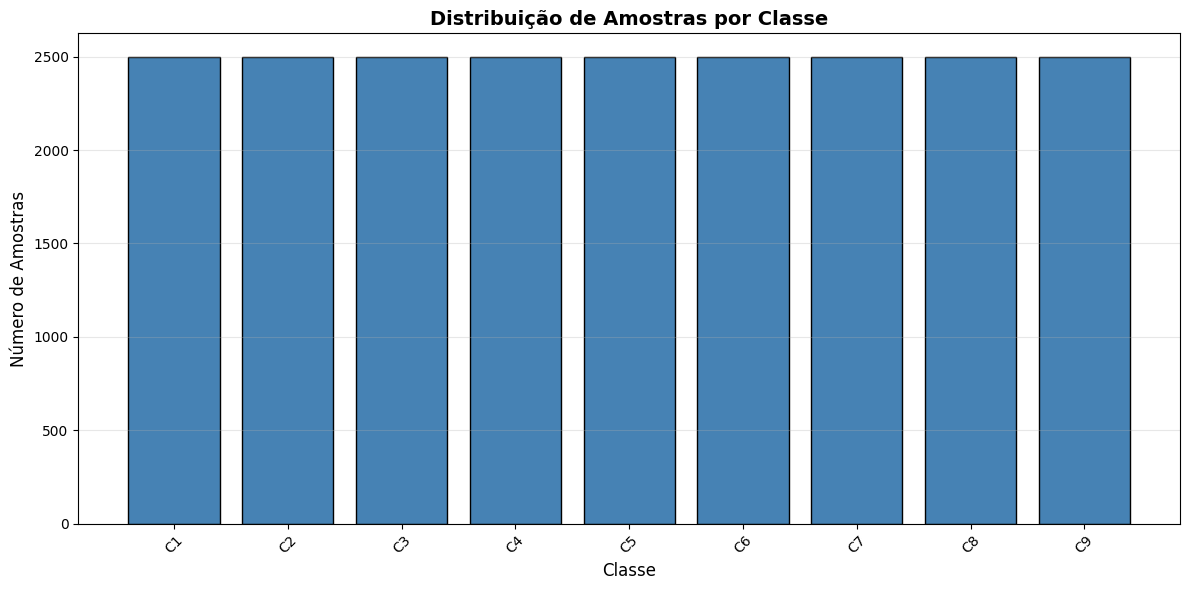

In [9]:
# Distribuição das classes
unique, counts = np.unique(dataset['labels'], return_counts=True)

print("\nDistribuição das Classes:")
for class_idx, count in zip(unique, counts):
    class_name = dataset['class_names'][class_idx]
    print(f"  Classe {class_idx:2d} ({class_name:30s}): {count:4d} amostras")

# Plotar distribuição
plt.figure(figsize=(12, 6))
plt.bar(range(len(counts)), counts, color='steelblue', edgecolor='black')
plt.xlabel('Classe', fontsize=12)
plt.ylabel('Número de Amostras', fontsize=12)
plt.title('Distribuição de Amostras por Classe', fontsize=14, fontweight='bold')
plt.xticks(range(len(counts)), [f'C{i+1}' for i in range(len(counts))], rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig(f'{DATASET_PATH}/distribuicao_classes.png', dpi=150, bbox_inches='tight')
plt.show()

## 9. Verificar Estrutura de Arquivos

In [10]:
# Verificar estrutura de diretórios criada
dataset_dir = Path(DATASET_PATH)

print(f"\nEstrutura do diretório '{DATASET_PATH}':")
print(f"  {dataset_dir}/")

# Listar subdiretórios (classes)
subdirs = sorted([d for d in dataset_dir.iterdir() if d.is_dir()])
for subdir in subdirs:
    n_files = len(list(subdir.glob('*.npy')))
    print(f"    ├── {subdir.name}/ ({n_files} arquivos)")

# Listar arquivos principais
files = sorted([f for f in dataset_dir.iterdir() if f.is_file()])
for f in files:
    size_mb = f.stat().st_size / (1024 * 1024)
    print(f"    ├── {f.name} ({size_mb:.2f} MB)")


Estrutura do diretório 'dataset':
  dataset/
    ├── C1_Normal/ (2500 arquivos)
    ├── C2_Sag/ (2500 arquivos)
    ├── C3_Swell/ (2500 arquivos)
    ├── C4_Interruption/ (2500 arquivos)
    ├── C5_Flicker/ (2500 arquivos)
    ├── C6_Transient/ (2500 arquivos)
    ├── C7_Harmonics/ (2500 arquivos)
    ├── C8_Notch/ (2500 arquivos)
    ├── C9_Spike/ (2500 arquivos)
    ├── complete_dataset.pkl (263.84 MB)
    ├── distribuicao_classes.png (0.04 MB)


## 10. Teste de Carregamento

In [11]:
# Testar carregamento do dataset
print("Testando carregamento do dataset...")

loaded_dataset = generator.load_dataset()

print(f"\nDataset carregado com sucesso!")
print(f"  Número de sinais: {len(loaded_dataset['signals'])}")
print(f"  Formato: {loaded_dataset['signals'].shape}")

# Verificar se os dados são idênticos
if np.array_equal(dataset['signals'], loaded_dataset['signals']):
    print("\n✓ Verificação OK: Dataset salvo e carregado são idênticos!")
else:
    print("\n✗ AVISO: Dados salvos e carregados diferem!")

Testando carregamento do dataset...
2025-11-25 22:23:43,839 - PowerQualityGenerator - INFO - Dataset carregado: 22500 sinais

Dataset carregado com sucesso!
  Número de sinais: 22500
  Formato: (22500, 1536)

✓ Verificação OK: Dataset salvo e carregado são idênticos!


## 11. Visualizar Amostras Aleatórias

In [ ]:
class_names[0]

'C1'

Visualizando amostras aleatórias...


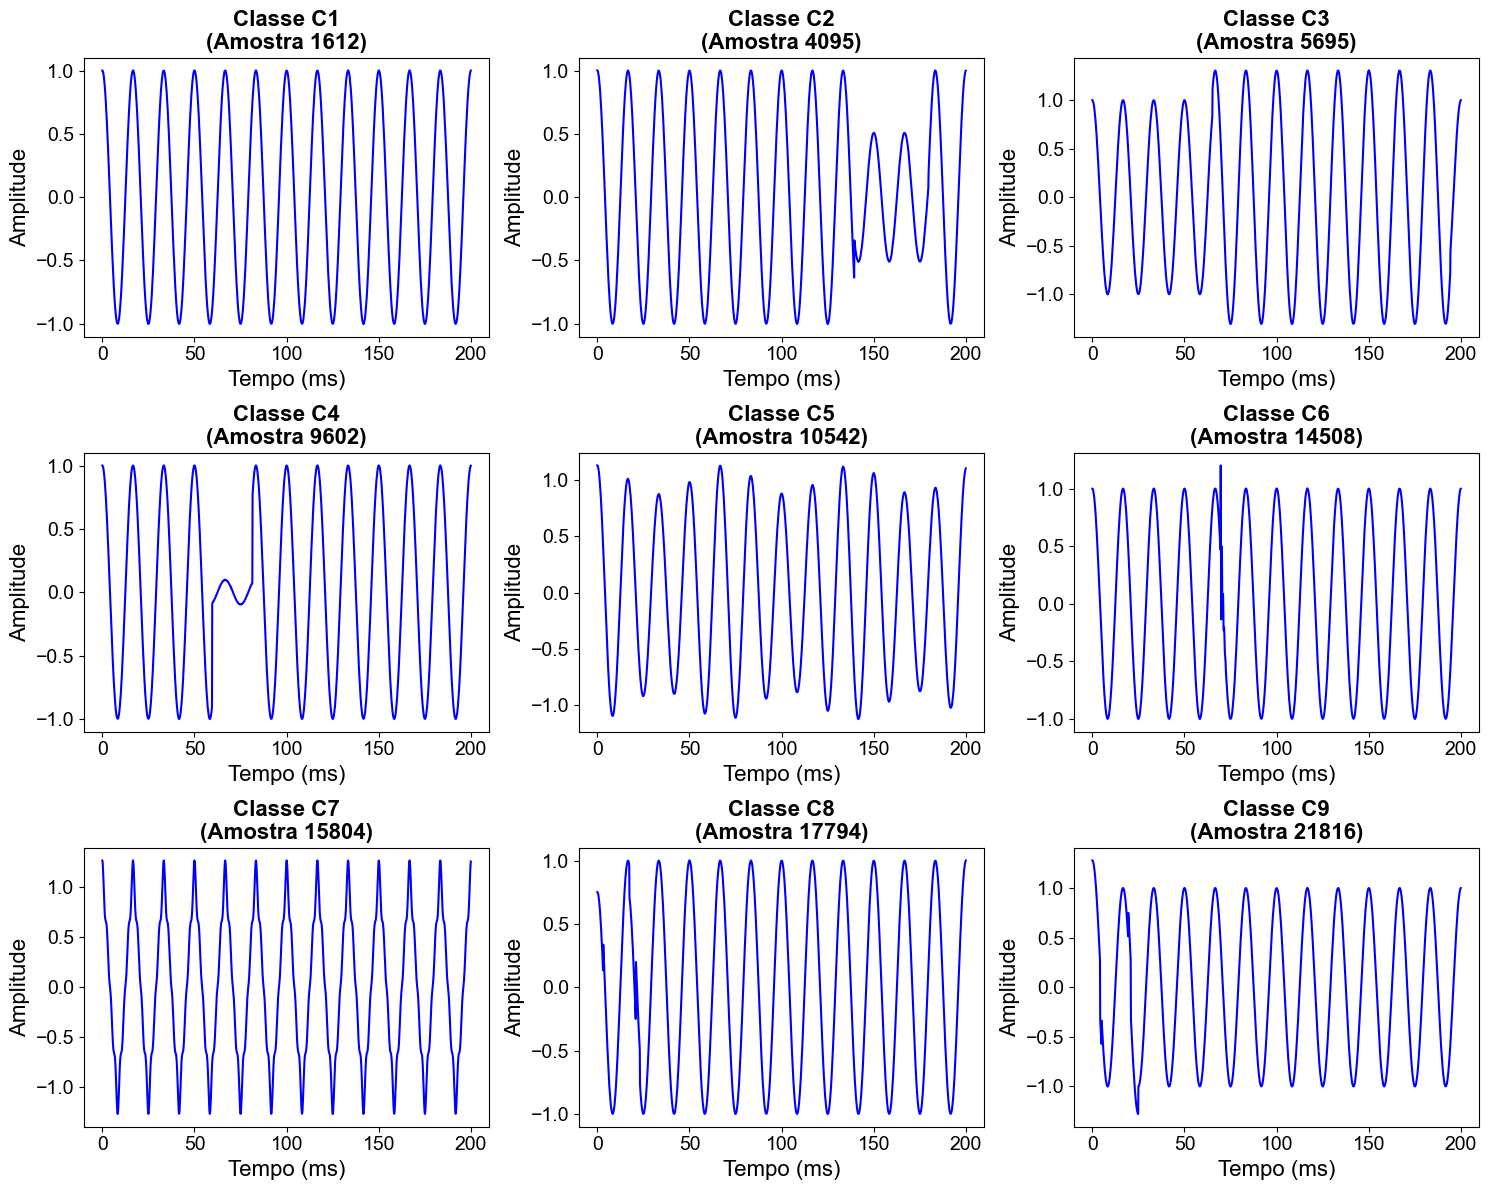

Visualização concluída!


In [125]:
# Plotar amostras aleatórias de cada classe
print("Visualizando amostras aleatórias...")

n_classes = len(class_names)

# Calcular layout do grid dinamicamente
n_cols = min(3, n_classes)  # Máximo 4 colunas
n_rows = int(np.ceil(n_classes / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))

# Garantir que axes seja sempre um array, mesmo com 1 subplot
if n_classes == 1:
    axes = np.array([axes])
else:
    axes = axes.flatten()

for class_idx in range(n_classes):
    # Encontrar índices desta classe
    class_indices = np.where(dataset['labels'] == class_idx)[0]
    
    # Escolher amostra aleatória
    random_idx = np.random.choice(class_indices)
    signal = dataset['signals'][random_idx]
    
    # Plotar
    axes[class_idx].plot(generator.t * 1000, signal, 'b-', linewidth=1.5)
    axes[class_idx].set_title(f'Classe {class_names[class_idx][0:2]}\n(Amostra {random_idx})', 
                              fontsize=16, fontweight='bold')
    axes[class_idx].set_xlabel('Tempo (ms)', fontsize=16)
    axes[class_idx].set_ylabel('Amplitude', fontsize=16)
    axes[class_idx].grid(False)
    axes[class_idx].tick_params(labelsize=6)
    axes[class_idx].tick_params(axis='both', labelsize=14)

# Remover subplots vazios se houver
total_subplots = n_rows * n_cols
for idx in range(n_classes, total_subplots):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.savefig(f'{DATASET_PATH}/amostras_aleatorias.png', dpi=150, bbox_inches='tight')
plt.show()

print("Visualização concluída!")

## 12. Resumo Final

In [13]:
print(f"\n{'='*60}")
print(f"RESUMO DA GERAÇÃO DO DATASET")
print(f"{'='*60}")
print(f"\n✓ Dataset gerado com sucesso!")
print(f"\nLocalização: {DATASET_PATH}/")
print(f"\nEstatísticas:")
print(f"  • Total de sinais: {len(dataset['signals'])}")
print(f"  • Número de classes: {len(class_names)}")
print(f"  • Amostras por classe: {SAMPLES_PER_CLASS}")
print(f"  • Amostras por sinal: {generator.n_samples}")
print(f"  • Frequência de amostragem: {generator.fs} Hz")
print(f"  • Duração do sinal: {generator.duration} s")
print(f"\nArquivos gerados:")
print(f"  • complete_dataset.pkl (dataset completo)")
print(f"  • 16 subdiretórios (um por classe)")
print(f"  • {len(dataset['signals'])} arquivos .npy individuais")
print(f"  • Gráficos de visualização")
print(f"\nTempo de geração: {elapsed_time:.2f} segundos")
print(f"\n{'='*60}")


RESUMO DA GERAÇÃO DO DATASET

✓ Dataset gerado com sucesso!

Localização: dataset/

Estatísticas:
  • Total de sinais: 22500
  • Número de classes: 9
  • Amostras por classe: 2500
  • Amostras por sinal: 1536
  • Frequência de amostragem: 7680.0 Hz
  • Duração do sinal: 0.2 s

Arquivos gerados:
  • complete_dataset.pkl (dataset completo)
  • 16 subdiretórios (um por classe)
  • 22500 arquivos .npy individuais
  • Gráficos de visualização

Tempo de geração: 29.80 segundos



# Outros Gráficos

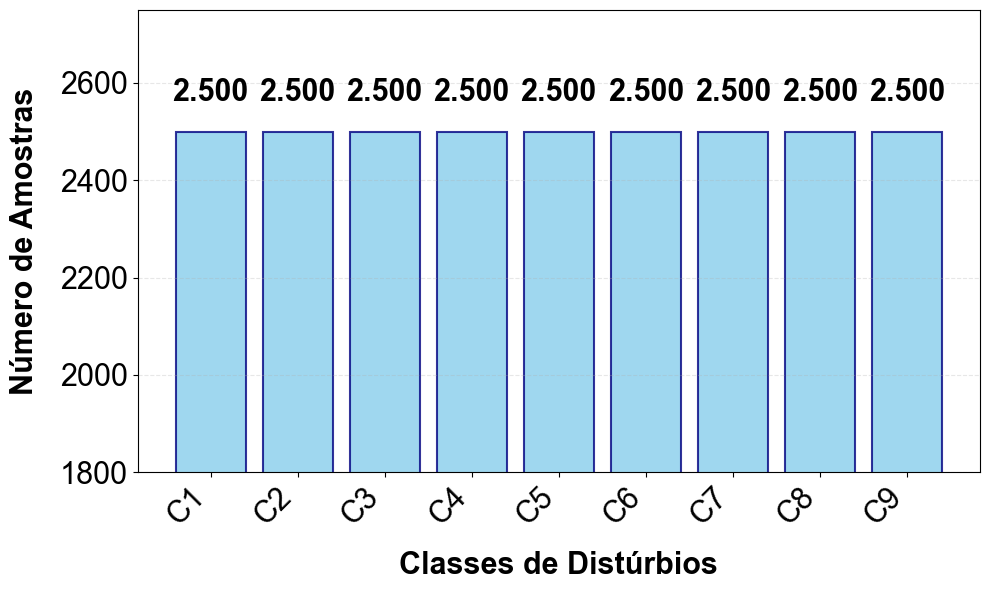

Gráfico de distribuição uniforme gerado com sucesso!
Total de amostras: 22.500


In [141]:
def plotar_distribuicao_uniforme(class_names, valores, tamanho_fonte_titulo=16, 
                                tamanho_fonte_eixos=14, tamanho_fonte_ticks=12):
    """
    Plota um gráfico de barras mostrando distribuição uniforme das classes
    
    Args:
        class_names: Lista com nomes das classes
        valores: Lista com valores para cada classe
        tamanho_fonte_titulo: Tamanho da fonte do título
        tamanho_fonte_eixos: Tamanho da fonte dos títulos dos eixos
        tamanho_fonte_ticks: Tamanho da fonte dos números dos eixos
    """
    import matplotlib as mpl
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Configurar separador decimal para vírgula e fonte
    mpl.rcParams['axes.formatter.use_locale'] = True
    mpl.rcParams['font.family'] = 'Arial'
    
    # Definir classes e valores
    classes = ['C1', 'C2', 'C3', 'C4','C5', 'C6', 'C7', 'C8', 'C9']
    
    # Criar figura
    plt.figure(figsize=(10,6))
    
    # Criar gráfico de barras
    bars = plt.bar(classes, valores, color='skyblue', edgecolor='navy', 
                  linewidth=1.5, alpha=0.8)
    
    # Configurar título e labels
    #plt.title('Distribuição de Classes', fontsize=tamanho_fonte_titulo, fontweight='bold', pad=20)
    plt.xlabel('Classes de Distúrbios', fontsize=tamanho_fonte_eixos, fontweight='bold', labelpad=15)
    plt.ylabel('Número de Amostras', fontsize=tamanho_fonte_eixos, fontweight='bold', labelpad=15)
    
    # Configurar ticks
    plt.xticks(rotation=45, ha='right', fontsize=tamanho_fonte_ticks)
    plt.yticks(fontsize=tamanho_fonte_ticks)
    
    # Adicionar valores em cima das barras
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 50,
                f'{int(height):,}'.replace(',', '.'),  # Formato brasileiro
                ha='center', va='bottom', fontsize=tamanho_fonte_ticks, 
                fontweight='bold')
        
    # Adicionar grid para melhor leitura
    plt.grid(True, axis='y', alpha=0.3, linestyle='--')
    
    # Ajustar limites do eixo Y para espaço dos valores
    plt.ylim(1800, max(valores) * 1.1)
    
    # # Adicionar linha de referência na média
    # media = np.mean(valores)
    # plt.axhline(y=media, color='red', linestyle=':', alpha=0.8, linewidth=2, 
    #             label=f'Média: {media:,.0f}'.replace(',', '.'))
    # plt.legend(fontsize=tamanho_fonte_ticks-1)
    
    # Ajustar layout
    plt.tight_layout()
    
    # Salvar figura
    plt.savefig('distribuicao_classes.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("Gráfico de distribuição uniforme gerado com sucesso!")
    print(f"Total de amostras: {sum(valores):,}".replace(',', '.'))

# Dados fornecidos

classes = ['C1', 'C2', 'C3', 'C4','C5', 'C6', 'C7', 'C8', 'C9']
valores = [2500] * 9  # Todas as classes com 2500 amostras

# Gerar o gráfico
plotar_distribuicao_uniforme(classes, valores, 
                            tamanho_fonte_titulo=18, 
                            tamanho_fonte_eixos=22, 
                            tamanho_fonte_ticks=22)